In [3]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import cftime
import pandas as pd

In [4]:
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [5]:
#To compute de climatoloy
yearC1='2004'
yearC2='2014'

# Read data

In [6]:
data_dir='/data/shareddata/Climatologias/cmems_mod_glo_phy_my_0.083_P1M-m/NC/'

In [7]:
files = []
for iy in range(2000,2021):
    for im in range(1,13):
        files.append(data_dir+"mercatorglorys12v1_gl12_mean_%04d%02d.nc"%(iy,im))

In [8]:
data = xr.open_mfdataset(files)

In [9]:
GL = data.drop_vars("mlotst").drop_vars("zos")
GL = GL.drop_vars("sithick").drop_vars("siconc")
GL = GL.drop_vars("usi").drop_vars("vsi").drop_vars("uo").drop_vars("vo").drop_vars("bottomT")

In [10]:
GL =  GL.rename({'longitude': 'lon','latitude': 'lat'})
GL

<xarray.Dataset> Size: 2TB
Dimensions:  (lon: 4320, lat: 2041, depth: 50, time: 252)
Coordinates:
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * lat      (lat) float32 8kB -80.0 -79.92 -79.83 -79.75 ... 89.83 89.92 90.0
  * depth    (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * time     (time) datetime64[ns] 2kB 2000-01-16T12:00:00 ... 2020-12-16T12:...
Data variables:
    thetao   (time, depth, lat, lon) float64 889GB dask.array<chunksize=(1, 7, 341, 720), meta=np.ndarray>
    so       (time, depth, lat, lon) float64 889GB dask.array<chunksize=(1, 7, 341, 720), meta=np.ndarray>
Attributes: (12/14)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...

In [11]:
DC=GL

## Data selection

In [12]:
DC_temp=GL.thetao.sel(lat=slice( -60, 60)).sel(depth=slice(0,2000))
DC_salt=GL.so.sel(lat=slice( -60, 60)).sel(depth=slice(0,2000))

## Seasonal cycle
Create seasonal climatology from yearC1 to yearC1 and the asociated anomaly

In [13]:
#Create monthly climatology
DC_temp_clim = DC_temp.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time');
DC_salt_clim = DC_salt.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time');

In [14]:
#Create anomaly
DC_temp_anom = DC_temp.groupby('time.month') - DC_temp_clim
DC_salt_anom = DC_salt.groupby('time.month') - DC_salt_clim

/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]


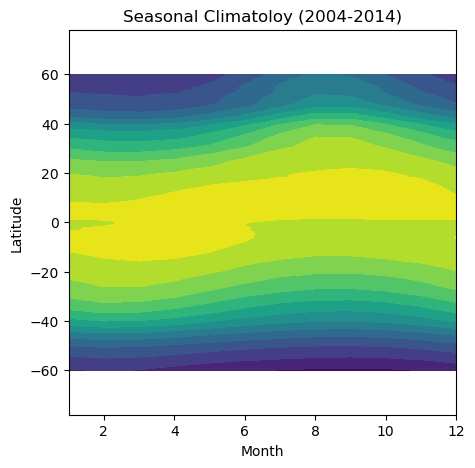

In [15]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").month,
                 DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").lat,
                 DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

# Mean weighted

In [16]:
weights = np.cos(np.deg2rad(DC_temp.lat))
weights = weights/weights.max()
weights.name = "weights"
DC_temp_weighted = DC_temp.weighted(weights)
DC_salt_weighted = DC_salt.weighted(weights)
DC_temp_anom_weighted = DC_temp_anom.weighted(weights)
DC_salt_anom_weighted = DC_salt_anom.weighted(weights)

DC_temp_wmean = DC_temp_weighted.mean(("lon", "lat"),skipna=True)
DC_salt_wmean = DC_salt_weighted.mean(("lon", "lat"),skipna=True)

DC_temp_anom_wmean = DC_temp_anom_weighted.mean(("lon", "lat"),skipna=True)
DC_salt_anom_wmean = DC_salt_anom_weighted.mean(("lon", "lat"),skipna=True)

## Smoothed versions

In [17]:
DC_temp_wmean_rolling = DC_temp_wmean.rolling(time=12,center=True).mean()
DC_salt_wmean_rolling = DC_salt_wmean.rolling(time=12,center=True).mean()

DC_temp_anom_wmean_rolling = DC_temp_anom_wmean.rolling(time=12,center=True).mean()
DC_salt_anom_wmean_rolling = DC_salt_anom_wmean.rolling(time=12,center=True).mean()

In [24]:
DC_temp_wmean.sel(depth=100,method="nearest")[0:10].values

array([17.04250313, 16.96017219, 16.92896603, 16.89355593, 16.91199484,
       16.98699968, 16.97896743, 16.90524253, 16.89263561, 16.93238533])

In [ ]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(DC_temp_wmean.time,DC_temp_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(DC_temp_wmean.time,DC_temp_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    #ax[i1].xaxis.set_tick_params(labelbottom=False)
    ax[i1].legend();
    i1=i1+1


In [ ]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(DC_temp_anom_wmean.time,DC_temp_anom_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(DC_temp_anom_wmean.time,DC_temp_anom_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    ax[i1].legend();
    i1=i1+1

## Global mean

In [30]:
DC_temp_global_2000m

<xarray.DataArray 'thetao' (time: 252)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(252,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-16T12:00:00 ... 2020-12-16T12:...

In [31]:
DC_temp_global_2000m=DC_temp_wmean.sel(depth=slice(0,2000)).mean("depth")
DC_temp_global_2000m.to_netcdf('./Data/GLORYS_temp_global_2000m.nc')

In [ ]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(DC_temp_global_2000m.time,DC_temp_global_2000m)
ax.grid(linestyle='-', linewidth=.9)

In [ ]:
DC_temp_anom_global_2000m=DC_temp_anom_wmean.sel(depth=slice(0,2000)).mean("depth")
DC_temp_anom_global_2000m.to_netcdf('./Data/GLORYS_temp_anom_global_2000m.nc')

In [ ]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(DC_temp_anom_global_2000m.time,DC_temp_anom_global_2000m)
ax.grid(linestyle='-', linewidth=.9)